Copyright **`(c)`** 2023 Ivan magistro Contenta `<s314356@polito.it>`  
[`https://github.com/ivanmag22/computational-intelligence`](https://github.com/ivanmag22/computational-intelligence)  

# LAB10

Use reinforcement learning to devise a tic-tac-toe player.

### Deadlines:

* Submission: December 25th
* Reviews: Jenuary 6th

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [173]:
from itertools import combinations
from collections import namedtuple, defaultdict
from random import choice, random, sample
import numpy as np
from tqdm.auto import tqdm
from copy import copy, deepcopy
import matplotlib.pyplot as plt

In [174]:
State = namedtuple('State', ['x', 'o'])

Given a square 3x3 where we play we define a function for win:
- we want to apply the magic square (the sum of each column and row should be 15): if one of the two players' moves make a sum of 15 then he wins
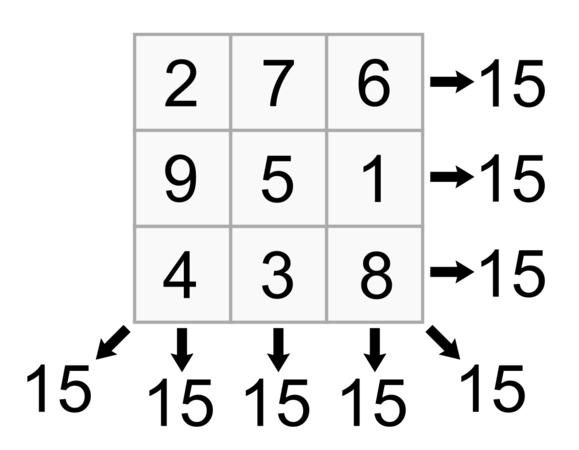

In [175]:
MAGIC = [2, 7, 6,
         9, 5, 1,
         4, 3, 8]   # magic square where the sum on the column, row and diagonal is 15

In [176]:
def print_board(state):
    """
    It prints the board in a given state
    """
    for r in range(3):
        for c in range(3):
            index = r * 3 + c
            if MAGIC[index] in state.x:
                print('X', end='')
            elif MAGIC[index] in state.o:
                print('O', end='')
            else:
                print('-', end='')
        print()
    print()

In [177]:
def win(elements):
    """
    It checks if elements is winning
    """
    return any(sum(c) == 15 for c in combinations(elements, 3))

def state_value(pos: State):
    """
    Evaluation position: +1 if the first player wins, -1 if the second player wins, otherwise 0
    """
    if win(pos.x):
        return 1
    elif win(pos.o):
        return -1
    else:
        return 0

## Model-free Reinforcement Learning
We will consider **model-free Reinforcement Learning**: we don't know anything about the environment, so we don't know environment model. The *idea* is doing random things. Its methods learn exclusively from trial-and-error, i.e. no modelling of the environment.

### Monte Carlo Approach
I'm generating a sequence of actions and at the end of the episode we compute the value fucntion as _v' = v + epsilon * (gamma* - gamma)_, where _v_ is the current value function of the state, _epsilon_ is a factor, _gamma*_ represents the final reward and _gamma_ represents again the current value function of the state.

We need a big dictionary for *state-value function*.

*Considerations*:
- State can not be put in dictionary because they are sets.
- Frozenset is like set. They are final, but not actionable (to review)

In [178]:
N_TRAINING = 20_000
MATCHES = 15

#### Training

In [179]:
def random_game():
    """
    It simulates a match between two random players and it tracks all the states of the game
    """
    trajectory = list()
    state = State(set(), set())  # empty state
                                # I add an element on both sides until one of the twos wins
    
    available = set(range(1, 9+1))  # available moves that a player can do
    while True:
        # move1 and move2 are the first and second players' move
        move1 = choice(list(available)) # now we pick one
        state.x.add(move1)  # state.x is a set
        trajectory.append(deepcopy(state))
        available.remove(move1)
        if win(state.x) or not available:   # not available is True if the set is empty, so there aren't other actions to pick
            return trajectory

        move2 = choice(list(available)) # now we pick one
        state.o.add(move2)  # state.o is a set
        trajectory.append(state)
        available.remove(move2)
        if win(state.o):
            return trajectory

In [180]:
def montecarlo(games):
    """
    It use the Monte Carlo approach to learn the moves by simulating a big number of games, which number is passed as argument

    Returns: the value function dictionary
    """
    value_dict = defaultdict(float)     # for each state (key) of the dictionary we have a value function
    epsilon = .001                      # it represents a weight

    for steps in tqdm(range(games)):  # 100 steps <-> 100 episodes <-> 100 games
        trajectory = random_game()
        final_reward = state_value(trajectory[-1])  # reward of the terminal state
        # update only at the end of the episode
        for state in trajectory:
            hashable_state = State(frozenset(state.x), frozenset(state.o))  # key composed by the state of the two players
            value_dict[hashable_state] = value_dict[hashable_state] + epsilon * (final_reward - value_dict[hashable_state]) # value updated by adding a "contribution"; value begins from 0, then it will be updated by adding eps*(final_reward - value)
    return value_dict

In [181]:
games = N_TRAINING
value_dict = montecarlo(games)
sorted(value_dict.items(), key=lambda e: e[1], reverse=True)[:10]  # in order to see the most promising games

100%|██████████| 20000/20000 [00:01<00:00, 11284.32it/s]


[(State(x=frozenset({5}), o=frozenset()), 0.4608145131478246),
 (State(x=frozenset({4, 5, 6, 7, 9}), o=frozenset({8, 1, 2, 3})),
  0.45952543708858457),
 (State(x=frozenset({4, 5, 6, 8, 9}), o=frozenset({1, 2, 3, 7})),
  0.43180049939794674),
 (State(x=frozenset({1, 5, 7, 8, 9}), o=frozenset({2, 3, 4, 6})),
  0.4232089348278637),
 (State(x=frozenset({2, 4, 5, 7, 8}), o=frozenset({9, 3, 6, 1})),
  0.41740917335996036),
 (State(x=frozenset({1, 4, 5, 7, 9}), o=frozenset({8, 2, 3, 6})),
  0.41155109401039114),
 (State(x=frozenset({1, 3, 4, 5, 6}), o=frozenset({8, 9, 2, 7})),
  0.41155109401039114),
 (State(x=frozenset({3, 4, 7, 8, 9}), o=frozenset({1, 2, 5, 6})),
  0.4026533445990531),
 (State(x=frozenset({1, 2, 4, 5, 8}), o=frozenset({9, 3, 6, 7})),
  0.3996576301731947),
 (State(x=frozenset({1, 2, 3, 4, 8}), o=frozenset({9, 5, 6, 7})),
  0.3996576301731947)]

#### Test

100%|██████████| 200000/200000 [00:19<00:00, 10406.57it/s]


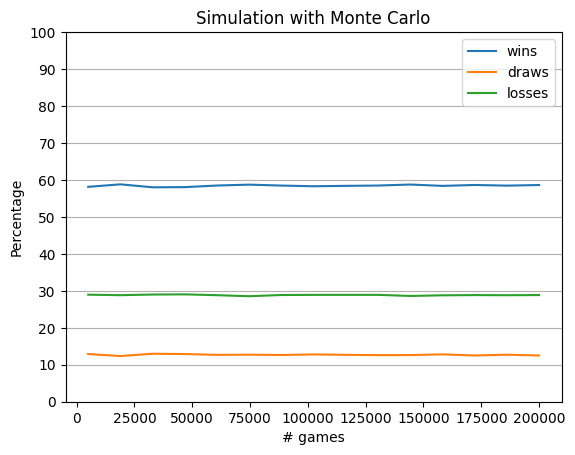

Average:
 Wins: 58.45576208901873 	Draws: 12.69550780020847 	Losses: 28.848730110772816


In [182]:
wins_l = []
draws_l = []
losses_l = []

l = [int(a*10**4) for a in np.linspace(0.5,20,MATCHES)]

for games in l:
    wins, draws, losses = [0, 0, 0]
    available = list(range(1,9+1))
    for steps in tqdm(range(games)):  # steps <-> episodes <-> games
        trajectory = random_game()
        final_reward = state_value(trajectory[-1])  # reward of the terminal state
        if final_reward == 1:
            wins += 1
        elif final_reward == -1:
            losses += 1
        else:
            draws += 1
    wins_l.append(wins*100/games)
    draws_l.append(draws*100/games)
    losses_l.append(losses*100/games)
plt.plot(l, wins_l, label='wins')
plt.plot(l, draws_l, label='draws')
plt.plot(l, losses_l, label='losses')
plt.title("Simulation with Monte Carlo")
plt.xlabel("# games")
plt.ylabel("Percentage")
plt.yticks(range(0,101,10))
plt.legend()
plt.grid(axis='y')
plt.show()
print("Average:\n","Wins:", sum(wins_l)/MATCHES, "\tDraws:", sum(draws_l)/MATCHES, "\tLosses:", sum(losses_l)/MATCHES)

It is possible to see that the percentage of victory is low!

Our goal is to increase this percentage. So we recur to *Q-Learning*!

### Q-learning
Q-learning is an *off-policy* algorithm, which means that, while learning a so-called target policy, it uses a so-called behaviour policy to select actions. The **behaviour policy** can either be an *ϵ-greedy*, a *softmax policy* or any other policy that can sufficiently explore the environment while learning.
Q-Learning is a form of temporal difference (TD) learning. It learns from incomplete sequences of experience (not necessarily full episodes) by updating estimates based on the current reward and the estimate of the next state's value. Q-Learning specifically deals with estimating action values (Q-values), which represent the expected return of taking a specific action in a specific state and following a particular policy thereafter.

#### Policies
As said before here there were adopted two kinds of behaviour policy:
- **ϵ-greedy policy** is a policy that chooses the best action (i.e. the action associated with the highest value) with probability 1−ϵ ∈ [0,1] (exploitation) and a random action with probability ϵ (exploration).
- **softmax policy** is a way to select actions based on the Q-values (the expected future rewards) of each action in a given state. The softmax function is used to convert these Q-values into a probability distribution over actions. Once you have the probabilities for each action, you can sample from this probability distribution to choose the action rather than simply choosing the action with the maximum probability.
It depends on three parameters:
    - *temperature*
    - *learning rate*
    - *discount rate*

In [183]:
EPSILON = 1/5

def epsilon_p(Q_s, actions):
    """
    Epsilon-policy: we have a probability epsilon to take randomly an action and a probability 1-epsilon to take the optimum action

    Args:
    Q_s: the array of Q for the specific state
    flag: the array that tells if the corresponding action was done or not (1 -> to do, 0 -> done)
    
    Returns:
    The index of the action to do
    """

    if random() > EPSILON:
        l = [value for key,value in Q_s.items() if key in actions]
        max_value = max(l)
        keys = [key for key, value in Q_s.items() if value == max_value and key in actions]
        random_key = choice(keys)
        return random_key
    else:
        a, = sample(list(actions), 1)
        return a

LR = .6     # learning rate
GAMMA = .6  # discount factor

def softmax_p(Q_s, actions, t):
    """
    Softmax policy: select the random actions with probabilities proportional to their current values, in order to not pick actions that are worse than others
    This policy probabilistically chooses actions based on their Q-values, allowing for a controlled level of exploration.
    Probability given by e^(Q_s(action)/TAU)/sum over all action(e^(Q_s(a)/TAU))
    Higher T values encourage more exploration.

    Args:
    Q_s: the array of Q for the specific state
    flag: the array that tells if the corresponding action was done or not (1 -> to do, 0 -> done)
    t: temperature
    
    Returns:
    The index of the action to pick
    """

    exp = [np.exp(value / t) for key,value in Q_s.items() if key in actions]
    prob = exp / np.sum(exp)
    cum_prob = np.cumsum(prob)
    action = np.argmax(cum_prob > random())
    l = list(actions)
    return l[action]

In [184]:
def q_learning(games, policy):
    # Q as matrix with two indexes, the state of the two players and the action that one of the two is going to pick
    
    quality_dict = defaultdict(float)
    available = set(range(1, 9+1))  # available moves that a player can do
    trajectory = list()

    for episode in tqdm(range(games)):  # steps <-> episodes <-> games
        t = 1 - episode/games
        state = State(set(), set())
        h_state = State(frozenset(), frozenset())
        if not h_state in quality_dict:
            quality_dict[h_state] = {key: 0 for key in range(1, 9+1)}
        actions = copy(available)
        while True:
            # player 1 - policy
            if policy is softmax_p:
                a = policy(quality_dict[h_state], actions, t)
            else:
                a = policy(quality_dict[h_state], actions)  # A_t picked by a specified policy
            
            new_state = deepcopy(state) # S_t+1 as copy of S_t
            new_state.x.add(a)  # S_t+1 with new action
            actions.remove(a)
            reward = state_value(new_state) # R_t+1
            h_new_state = State(frozenset(new_state.x), frozenset(new_state.o))
            if not h_new_state in quality_dict:
                quality_dict[h_new_state] = {key: 0 for key in range(1, 9+1)}
            quality_dict[h_state][a] = quality_dict[h_state][a] + LR * (reward + GAMMA * max(quality_dict[h_new_state].values()) - quality_dict[h_state][a])
            state = new_state   # t <- t+1
            h_state = h_new_state
            
            trajectory.append(deepcopy(state))
            if win(state.x) or not actions:
                break
            
            # player 2 - random
            a = choice(list(actions))   # A_t picked randomly from the list of available actions
            
            new_state = deepcopy(state) # S_t+1 as copy of S_t
            new_state.o.add(a)  # S_t+1 with new action
            actions.remove(a)
            reward = state_value(new_state) # R_t+1
            h_new_state = State(frozenset(new_state.x), frozenset(new_state.o))
            if not h_new_state in quality_dict:
                quality_dict[h_new_state] = {key: 0 for key in range(1, 9+1)}
            quality_dict[h_state][a] = quality_dict[h_state][a] + LR * (reward + GAMMA * max(quality_dict[h_new_state].values()) - quality_dict[h_state][a])
            state = new_state   # t <- t+1
            h_state = h_new_state
            
            trajectory.append(deepcopy(state))
            if win(state.o):
                break

    return quality_dict

## Epsilon policy
### Training

In [185]:
games = N_TRAINING
policy = epsilon_p
q = q_learning(games, policy)

  1%|          | 236/20000 [00:00<00:08, 2204.67it/s]

100%|██████████| 20000/20000 [00:06<00:00, 2879.05it/s]


In [186]:
q   # Quality dictionary

defaultdict(float,
            {State(x=frozenset(), o=frozenset()): {1: 0.1296,
              2: 0.12959999999999997,
              3: 0.1295994385853399,
              4: 0.1296,
              5: 0.12959999095044264,
              6: 0.1296,
              7: 0.12959999999999583,
              8: 0.12959998404348572,
              9: 0.12959779814724162},
             State(x=frozenset({7}), o=frozenset()): {1: 0.21354235468368912,
              2: 0.21599914894387215,
              3: 0.21599980238422745,
              4: 0.21599466625636635,
              5: 0.2159999999999933,
              6: 0.07740026285809647,
              7: 0,
              8: 0.2159999998021958,
              9: 0.21508085340302968},
             State(x=frozenset({7}), o=frozenset({2})): {1: 0.0,
              2: 0,
              3: 0.35999923179264487,
              4: 0.0,
              5: 0.07776,
              6: 0.06748825007554558,
              7: 0,
              8: 0.0,
              9: 0.0},
    

### Test
At the end we use the Q dictionary in order to run some games between the q-learning player and the random player to obtain the percentages of wins, draws and losses.

100%|██████████| 200000/200000 [00:19<00:00, 10095.01it/s]


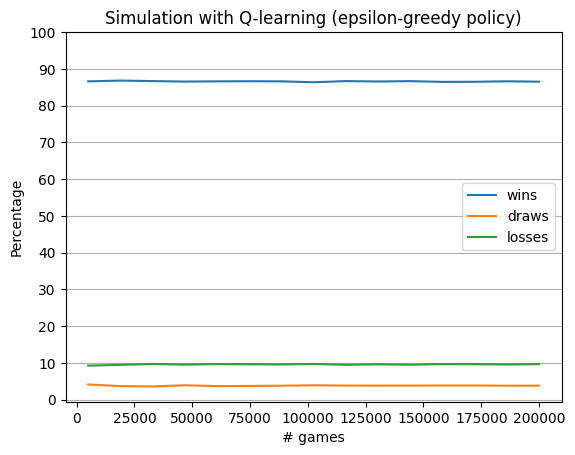

Average:
 Wins: 86.59067572599369 	Draws: 3.8217688205956586 	Losses: 9.58755545341066


In [187]:
wins_l = []
draws_l = []
losses_l = []

l = [int(a*10**4) for a in np.linspace(0.5,20,MATCHES)]

for games in l:
    wins, draws, losses = [0, 0, 0]
    available = list(range(1,9+1))
    for game in tqdm(range(games)):
        state = State(set(), set())
        actions = copy(available)
        while True:
            h_state = State(frozenset(state.x), frozenset(state.o))
            if not h_state in q:
                q[h_state] = {key: 0 for key in range(1, 9+1)}
            a = policy(q[h_state], actions)  # A_t picked by a specified policy
            new_state = deepcopy(state) # S_t+1 as copy of S_t
            new_state.x.add(a)  # S_t+1 with new action
            actions.remove(a)
            state = new_state   # t <- t+1

            if win(state.x):
                wins += 1
                break

            elif not actions:
                draws += 1
                break
            
            # player 2 - random
            a = choice(list(actions))   # A_t picked randomly from the list of available actions
            state.o.add(a)  # S_t+1 with new action
            actions.remove(a)
            state = new_state   # t <- t+1
            if win(state.o):
                losses += 1
                break
    wins_l.append(wins*100/games)
    draws_l.append(draws*100/games)
    losses_l.append(losses*100/games)
plt.plot(l, wins_l, label='wins')
plt.plot(l, draws_l, label='draws')
plt.plot(l, losses_l, label='losses')
plt.title("Simulation with Q-learning (epsilon-greedy policy)")
plt.xlabel("# games")
plt.ylabel("Percentage")
plt.yticks(range(0,101,10))
plt.legend()
plt.grid(axis='y')
plt.show()
print("Average:\n","Wins:",sum(wins_l)/MATCHES, "\tDraws:",sum(draws_l)/MATCHES,"\tLosses:", sum(losses_l)/MATCHES)

## Softmax policy
### Training

In [188]:
games = N_TRAINING
policy = softmax_p
q = q_learning(games, policy)

  0%|          | 0/20000 [00:00<?, ?it/s]

 99%|█████████▉| 19845/20000 [00:09<00:00, 2764.98it/s]C:\Users\ivanm\AppData\Local\Temp\ipykernel_7284\3447279727.py:44: RuntimeWarning: overflow encountered in exp
  exp = [np.exp(value / t) for key,value in Q_s.items() if key in actions]
C:\Users\ivanm\AppData\Local\Temp\ipykernel_7284\3447279727.py:45: RuntimeWarning: invalid value encountered in divide
  prob = exp / np.sum(exp)
100%|██████████| 20000/20000 [00:09<00:00, 2076.22it/s]


### Test
At the end we use the Q dictionary in order to run some games between the q-learning player and the random player to obtain the percentages of wins, draws and losses.

 91%|█████████▏| 4563/5000 [00:01<00:00, 4290.82it/s]C:\Users\ivanm\AppData\Local\Temp\ipykernel_7284\3447279727.py:44: RuntimeWarning: overflow encountered in exp
  exp = [np.exp(value / t) for key,value in Q_s.items() if key in actions]
C:\Users\ivanm\AppData\Local\Temp\ipykernel_7284\3447279727.py:45: RuntimeWarning: invalid value encountered in divide
  prob = exp / np.sum(exp)
 98%|█████████▊| 32339/32857 [00:07<00:00, 5261.76it/s]c:\Users\ivanm\Desktop\Poli\Magistrale\2_ANNO\Computational_Intelligence\Exercises\venv\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|██████████| 200000/200000 [00:56<00:00, 3536.20it/s]


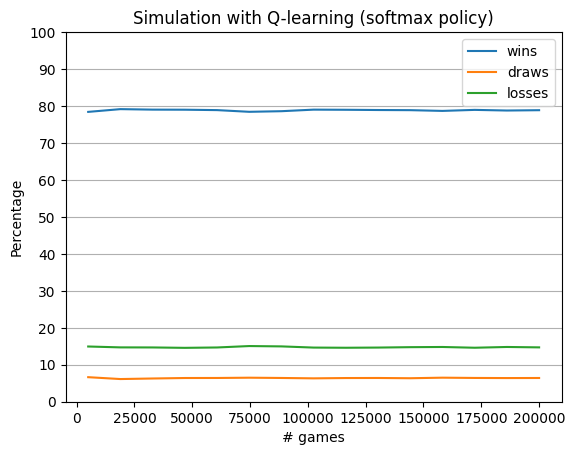

Average:
 Wins: 78.84648872334519 	Draws: 6.406189919541619 	Losses: 14.747321357113183


In [189]:
wins_l = []
draws_l = []
losses_l = []

l = [int(a*10**4) for a in np.linspace(0.5,20,MATCHES)]

for games in l:
    wins, draws, losses = [0, 0, 0]
    available = list(range(1,9+1))
    for game in tqdm(range(games)):
        t = 1 - game/games
        state = State(set(), set())
        actions = copy(available)
        while True:
            h_state = State(frozenset(state.x), frozenset(state.o))
            if not h_state in q:
                q[h_state] = {key: 0 for key in range(1, 9+1)}
            a = policy(q[h_state], actions, t)  # A_t picked by a specified policy
            new_state = deepcopy(state) # S_t+1 as copy of S_t
            new_state.x.add(a)  # S_t+1 with new action
            actions.remove(a)
            state = new_state   # t <- t+1

            if win(state.x):
                wins += 1
                break

            elif not actions:
                draws += 1
                break
            
            # player 2 - random
            a = choice(list(actions))   # A_t picked randomly from the list of available actions
            state.o.add(a)  # S_t+1 with new action
            actions.remove(a)
            state = new_state   # t <- t+1
            if win(state.o):
                losses += 1
                break
    wins_l.append(wins*100/games)
    draws_l.append(draws*100/games)
    losses_l.append(losses*100/games)
plt.plot(l, wins_l, label='wins')
plt.plot(l, draws_l, label='draws')
plt.plot(l, losses_l, label='losses')
plt.title("Simulation with Q-learning (softmax policy)")
plt.xlabel("# games")
plt.ylabel("Percentage")
plt.yticks(range(0,101,10))
plt.legend()
plt.grid(axis='y')
plt.show()
print("Average:\n","Wins:",sum(wins_l)/MATCHES, "\tDraws:",sum(draws_l)/MATCHES,"\tLosses:", sum(losses_l)/MATCHES)

With softmax policy more time is needed.
It is good, but it performes less well than greedy-policy.
Maybe it depends by the hyper-parameters.
With discount rate = .6 I obtain better results than discount rate = .25.
It is better with a fixed TAU than a one that decreases.